<p style="color: #111; font-family: 'Open Sans', sans-serif; font-size: 16px; line-height: 28px; margin: 0 0 48px; ">
<h2 style="color: #111; font-family: 'Open Sans Condensed', sans-serif; font-size: 44px; font-weight: 700; line-height: 48px; margin: 0 0 24px; padding: 0 30px; text-align: center; text-transform: uppercase;"> Deep Learning Project </h2> 
<h1 style="color: #111; font-family: 'Open Sans Condensed', sans-serif; font-size: 64px; font-weight: 700; line-height: 64px; margin: 0 0 0; padding: 20px 30px; text-align: center; text-transform: uppercase;">Image Super-Resolution</h1> 

</p>

Course Instructor:  Nikos Deligiannis  

Teaching Assistants:
- Lusine Abrahamyan
- Giannis Bekoulis

Student Group:
+ Esteban Velásquez Rendón
+ Andrzej Krzysztof Pietrusiak
+ Amna Jouini

<p style="font-size: 12px; text-align: center;">MSc. Applied Computer Science 2021-2022</p> 



&nbsp;  

&nbsp;  
&nbsp;  
# Imports and prerequisites
To run this jupyter notebook, following requirements must be fullfilled:  
**python** in version **3.6.9** with subsequent modules in versions:  

- opencv-python ==                4.5.5.62
- tqdm ==                           4.62.3
- matplotlib ==                    3.3.4
- torch    ==                     1.10.1+cu113
- torchaudio     ==               0.10.1+cu113
- torchvision                   0.11.2+cu113
- scikit-image     ==             0.17.2



After modules are installed, import all packages running next cell.

In [1]:
import cv2 
import os  
from tqdm.notebook import tqdm 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import gc
from skimage.metrics import structural_similarity as ssim
import sys

&nbsp;  

&nbsp;  
&nbsp;  


# Required folder structure


Before importing data make sure project has following structure: 

<pre>
project folder:  
│  
│── main.ipynb  
│   
├────data    
│     ├───DIV2K_train_HR/
│     ├───DIV2K_valid_HR/
│     ├───DIV2K_train_LR_bicubic/
│     └───DIV2K_valid_LR_bicubic/
└────results
      ├───loss/  
      ├───models/  
      ├───patch_results/  
      └───metrics/  
      
</pre>

main.ipynb is currently read file. To work properly jupyter kernel path has to be set to the directory containint main.ipynb, this can be achieved by running jupyter kernel from the directory. In the same directory program should find data folder with folders containing png images. They don't necesary belong to the DIV2K data set, but folder should contain images with same dpi. results folder with all its subfolders showed above is creates placeholder structure for the upcoming results.

&nbsp;  

&nbsp;  
&nbsp;  

&nbsp;  
<h1 style="text-align:center;font-size: 50px"> Data preprocessing</h1>


This section definies and runs function used in data preprocessing. Main functions **create_patches(...)** may look intimidating, however it wraps multiple steps used in preprocessing and outputs ready to use tensors, which is convenient and less error-prone for use. Usege requires defining:
- path folder with png images
- size of the patches which will be extracted from the read images
- number of patches after which process stops
- resolution divider by which patches should be downsampled and upsampled from extracted high resolution patches  
- what percent of the generated patches should become part of the trainset, the rest will create testset
- last option called skip_big_images allows to skip process of saving orginal images in the memory, storing onl patches (which is desired to reduce RAM usage)

Following actions are performed inside of it after:
- images are read from the disk one by one
- for each image high-resolution patches are extracted by cropping window which is sliding through whole image
- low-resolution patches are then created for every high-resolution pathch, (this is done by downsampling and upsampling operations)
- (evantual low-resolution versions of full-scale images)
- conversion to numpy format
- normalizaiton of image intensites to values beetween 0 and 1
- conversion to torch tensor format

In [34]:
def create_patches(path:str ,patch_size=(150,150), N_of_pathches=1, resolution_divider=10, train_percent:float= 0.8, skip_big_images=False):
    """ spefyfing skip_big_images=True, saves RAM
    """
    if path[-1] != '/':
        path+= '/'
    i=0

    hr_big=[]
    patch_hr=[]
    file_names=[]

    # READ FILES, GET patches in high resolution
    with tqdm(total=N_of_pathches, desc='reading from disk, generating patches') as pbar:
    
        class enough_patches(Exception):
            pass
        try:
            for file in os.listdir(path) :

                if file.split(".")[-1] != "png": # IF FILE FORMAT NOT CORRECT -> SKIP
                    print("Not a png file")
                    continue
                i+=1
                #Read image, acomodate its size
                img = cv2.imread(path + file)   

                if img.shape[0]< patch_size[0] or img.shape[1] < patch_size[1]: # IMG SMALLER THAN PATCH
                    continue

                file_names.append(file)
                if not skip_big_images:
                    hr_big.append(img)

                w,h=int(patch_size[0]/1.01), int(patch_size[1]/1.01)
                for x in range(0, img.shape[0]-h, h ):
                    for y in range(0, img.shape[1]-w, w ):
                        cropped= img[x:x+h, y:y+w]
                        patch_hr.append(cropped)
                        pbar.update(1)
                        if len(patch_hr) >= N_of_pathches:
                            raise enough_patches
                
        except enough_patches:
            pass

    # GET downsampled and upsampled patches from previously read data
    try:
        with tqdm(total=len(patch_hr), desc='down/up sampling') as pbar2:
            patch_lr=[]
            for p_hr in patch_hr:
                new_size_reversed= (int(p_hr.shape[1]/resolution_divider), int(p_hr.shape[0]/resolution_divider))
                downsampled = cv2.resize(p_hr, new_size_reversed, interpolation = cv2.INTER_AREA) # cv.resize takes (second, first) dimenstion so if you want output (4,2). ou pass (2,4)
                old_size_reversed= (p_hr.shape[1], p_hr.shape[0])
                upsampled= cv2.resize(downsampled, old_size_reversed, interpolation=cv2.INTER_CUBIC) 
                patch_lr.append(upsampled)
                pbar2.update(1)
    except cv2.error as e:
        print("\033[31mERROR WHILE RESCALING PATCHES, (PATCH PROBABLY TO SMALL, I can't upscale 1 pixel, dude!)\033[0m")
        print (e)
        return None, None, None, None,  hr_big, None, file_names

    if not skip_big_images:
        # GET downsampled and upsampled bigimages from previously read data
        with tqdm(total=len(hr_big), desc='down/up sampling lr_big') as pbar3:
            lr_big=[]
            for p_hr in hr_big:
                #print("p_hr.shape=", p_hr.shape)
                new_size_reversed=(int(p_hr.shape[1]/resolution_divider), int(p_hr.shape[0]/resolution_divider)) # cv.resize takes (second, first) dimenstion
                #print("new_size_reversed=", new_size_reversed)
                downsampled = cv2.resize(p_hr, new_size_reversed, interpolation = cv2.INTER_AREA)
                #print("downsampled.shape=", downsampled.shape)
                old_size_reversed= (p_hr.shape[1], p_hr.shape[0])
                #print("old_size_reversed=", old_size_reversed)
                upsampled= cv2.resize(downsampled, old_size_reversed, interpolation=cv2.INTER_CUBIC) 
                #print("upsampled.shape=", upsampled.shape)
                lr_big.append(upsampled)
                pbar3.update(1)
    
    #Pathes lists To numpy
    print("Converting to numpy...", end=" ")
    patch_hr=np.array(patch_hr)
    patch_lr=np.array(patch_lr)
    print("\033[92m done \033[0m")

    

    # Train-Test split
    print("Splitting for Train-Test...", end=" ")
    indices = np.random.permutation(patch_hr.shape[0])
    split_point=int(patch_hr.shape[0]*train_percent)
    training_idx, test_idx = indices[:split_point], indices[split_point:] 
    hr_train, hr_test = patch_hr[training_idx,:], patch_hr[test_idx,:]
    lr_train, lr_test = patch_lr[training_idx,:], patch_lr[test_idx,:]
    del patch_hr, patch_lr, indices, split_point
    gc.collect()
    print("\033[92m done \033[0m")

    # Acomodating data type
    hr_train=   hr_train.astype("float32")
    lr_train=   lr_train.astype("float32")
    hr_test=    hr_test.astype ("float32")
    lr_test=    lr_test.astype ("float32")

    if not skip_big_images:
        for i in range(len(hr_big)):
            hr_big[i]= hr_big[i].astype("float32")   ; 
            lr_big[i]= lr_big[i].astype("float32")   ; 


    # Normalization
    print("Normalization...", end=" ")
    hr_train/=  255.0; sys.stdout.write('\rNormalization 1/6...');sys.stdout.flush() 
    lr_train/=  255.0; sys.stdout.write('\rNormalization 2/6...');sys.stdout.flush() 
    hr_test/=   255.0; sys.stdout.write('\rNormalization 3/6...');sys.stdout.flush() 
    lr_test/=   255.0; sys.stdout.write('\rNormalization 4/6...');sys.stdout.flush() 
    


    if not skip_big_images:
        for i in range(len(hr_big)):
            hr_big[i]= hr_big[i] / 255.0    ; sys.stdout.write('\rNormalization 5/6...');sys.stdout.flush() 
            lr_big[i]= lr_big[i] / 255.0    ; sys.stdout.write('\rNormalization 6/6...');sys.stdout.flush() 
    print("\rNormalization 6/6... \033[92m done \033[0m")

    # if len(hr_big) == 1:
    #     hr_big=np.expand_dims(hr_big, axis=0)

    # from numpy to tensors
    print("Converting to tensors...", end=" ")
    hr_train=   torch.tensor(   np.transpose(hr_train,       (0, 3, 1, 2) ) )   ; sys.stdout.write('\rConverting to tensors 1/6...');sys.stdout.flush() 
    lr_train=   torch.tensor(   np.transpose(lr_train,       (0, 3, 1, 2) ) )   ; sys.stdout.write('\rConverting to tensors 2/6...');sys.stdout.flush() 
    hr_test=    torch.tensor(   np.transpose(hr_test,        (0, 3, 1, 2) ) )   ; sys.stdout.write('\rConverting to tensors 3/6...');sys.stdout.flush() 
    lr_test=    torch.tensor(   np.transpose(lr_test,        (0, 3, 1, 2) ) )   ; sys.stdout.write('\rConverting to tensors 4/6...');sys.stdout.flush() 
    
    if not skip_big_images:
        for i in range(len(hr_big)):
            hr_big[i]= torch.tensor(np.transpose(hr_big[i], (2,0,1)  )    )     ; sys.stdout.write('\rConverting to tensors 5/6...');sys.stdout.flush() 
            lr_big[i]= torch.tensor(np.transpose(lr_big[i], (2,0,1)  )    )     ; sys.stdout.write('\rConverting to tensors 6/6...');sys.stdout.flush() 

    print("\rNormalization 6/6... \033[92m done \033[0m")


    if hr_train.dtype!=torch.float32 or lr_train.dtype!=torch.float32 or hr_test.dtype!=torch.float32 or lr_test.dtype!=torch.float32:
        raise TypeError

    print("\033[92mAll done! \033[0m")
    print("big images used:", len(file_names), "  out of: ", len(list(os.listdir(path))))
    if not skip_big_images:
        return hr_train, lr_train, hr_test, lr_test, hr_big, lr_big, file_names
    else:
        return hr_train, lr_train, hr_test, lr_test, None, None, file_names
# End of the functions




resolution_div = 3
n_patches = 100  # for now 17K max (for 16GB RAM, resolution_div = 10,  patch_size=(150,150), load_only_training=True)
patch_size=(96,96)

hr_train, lr_train, hr_test, lr_test,  hr_big, lr_big, file_names= create_patches(
    
                                                path="./data/DIV2K_train_HR", 
                                                N_of_pathches=n_patches, 
                                                patch_size=patch_size,
                                                resolution_divider=resolution_div, 
                                                skip_big_images=False,
                                                                                )

reading from disk, generating patches:   0%|          | 0/100 [00:00<?, ?it/s]

down/up sampling:   0%|          | 0/100 [00:00<?, ?it/s]

down/up sampling lr_big:   0%|          | 0/1 [00:00<?, ?it/s]

Converting to numpy...  done 
Splitting for Train-Test...  done 
Normalization 6/6...  done 
Normalization 6/6...  done 
All done! 
big images used: 1   out of:  318


# Ploting helper functionality
For the results presentation reasons as well as debugging process, we created our plotting functions which can accept many diffrent formats and plot them.


In [30]:
def plot(img,n=2,path=None):
    if type(img)==np.ndarray:
        if len(img.shape) ==3 :
            if img.shape[-1]==3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
            if img.shape[0]==3:
                img=np.transpose(img, (1,2,0) )
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow( img)
        elif len(img.shape) ==4:
            img=img[0]
            img=np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow( img)   

    elif type(img)==torch.Tensor:
        img=img.detach().numpy()
        if len(img.shape)==4:
            img=img[0]
            img=np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow( img)
        else:
            img= np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img )
    elif type(img)==list:
        if len(img)>1:
            figsize=( 20,n*4)
            fig, axs = plt.subplots(n, 1, figsize=figsize, dpi=80)
            for j,(ax, i) in enumerate(zip(axs,img)):
                i=i.numpy()
                i= np.transpose(i, (1,2,0) )
                i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
                ax.imshow(i )
                if j > n:
                    break
        if len(img)==1:
            img=img[0]
            img=img.detach().numpy()
            img=np.transpose(img, (1,2,0) )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow( img)
    if(path!=None):
        #plt.savefig(path,facecolor='white', edgecolor='none', dpi=300)
        plt.savefig(path, dpi=300)

#### How to use plot() to create subplot
Since above cell is just defining plot function, in below cell we can see how can it be used.

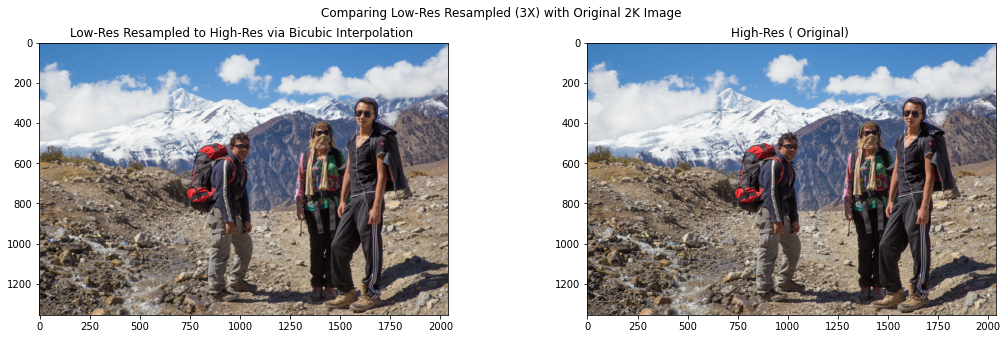

In [43]:
plt.figure(figsize = (18,5))
plt.subplot(121); plt.suptitle("Comparing Low-Res Resampled (%dX) with Original 2K Image"%resolution_div)
plot(lr_big[0]); plt.title("Low-Res Resampled to High-Res via Bicubic Interpolation ")
plt.subplot(122)
plot(hr_big[0]) ; plt.title("High-Res ( Original) ");

### Reseting GPU Allocated Memory
Cell run occasionally, in situations where GPU memory needs to be cleared from previous tensors, to make space to new ones.

In [4]:
import gc
gc.collect()
torch.cuda.empty_cache()
try:
    del result
    del IN
    del OUT
    del mySRCNN
except NameError: print("OK")
a = torch.cuda.memory_allocated(0)
print("memory_allocated = ",a)
b = torch.cuda.memory_reserved(0)
print("memory_reserved = ",b)

OK
memory_allocated =  0
memory_reserved =  0


# Allocating Resources in GPU
This code supports operations done on GPU and TPU, running following cell is detecting thype of hardware which is accessible and moves tensors (so input and label data) to it.

In [3]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
  torch.cuda.init()
else:  
  dev = "cpu"
devO = torch.device(dev) 
# Allocating Tensors
lr_train = lr_train.to(devO)
hr_train = hr_train.to(devO)
lr_test = lr_test.to(devO)
hr_test = hr_test.to(devO)
print("Source: ", devO)

Source:  cuda:0


# SRCNN class
In following cell, model architecture is defined. It is composed of 3 layers:
1. Tensor of low-resolution patches is fed into first convolutional layer. After performing set of convolution on each of the patches is represented in multiple dimensions (also called feature maps). Performed convolution are used with specyfic padding which outpus results of the same width and height.  
2. Next layer maps created feature-maps by previous layer to smaller set of feature maps.
3. Last step of the model is responsible for squishing tensor recived from the previous layer into output RGB image.

Layers 1 and 2 are passed to activation function Relu, while 3 is not. Final output undergo clamping so its results are bounded between 0 and 1.

In [5]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=2*64, kernel_size=9, padding= 9//2) # output tensor shape (*, 64,H,W)
        self.conv2 = nn.Conv2d(2*64, out_channels=32, kernel_size=5, padding=5 // 2) # output tensor shape (*,32,H,W)
        self.pix=  nn.PixelShuffle(2)
        
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu =  nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return torch.clamp(x, min=0.0, max=1.0)

# Training
Follwing cell was used to train the model. In the begining hyperparameters are defined. In the loop training is performed, each epoch is reported to tqdm module with its progress. After training model is saved to file.

In [6]:
mySRCNN=SRCNN()
mySRCNN.to(devO)
mySRCNN.train()
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(mySRCNN.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(mySRCNN.parameters(), lr=learning_rate)
batch_size=16
running_loss = 0.0
epochs=60
loss_vals=[]
best_epoch=0

mySRCNN.train()
for e in tqdm(range(epochs)):
        for i in range(0, len(lr_train), batch_size):  # loop over the dataset multiple times

                batch_x=  lr_train[i:i+batch_size]
                batch_y=  hr_train[i:i+batch_size]
                
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = mySRCNN(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        loss_vals.append(loss.item())
print('Finished Training')
mySRCNN.eval()
torch.save(mySRCNN.state_dict(),'./results/models/19_SRCNN [{}-epochs] [{}-lr] [{}-optim] [{}-batch_size] [{}-train_size] [{}X] [patch_shape: {}]'.format(epochs,learning_rate,str(type(optimizer)).split(".")[-1].split("'")[0],batch_size,n_patches,resolution_div, patch_size))

  0%|          | 0/60 [00:00<?, ?it/s]

Finished Training


## Testing the Model (PATCHES)

In [9]:
results= mySRCNN(lr_test[200:400]) # ONLY PATCHES
IN_cpu_np=lr_test.cpu().numpy()
result_cpu_np = results.cpu().detach().numpy()
GT_cpu_np= hr_test.cpu().numpy()

### Plotting Patches Comparison Results

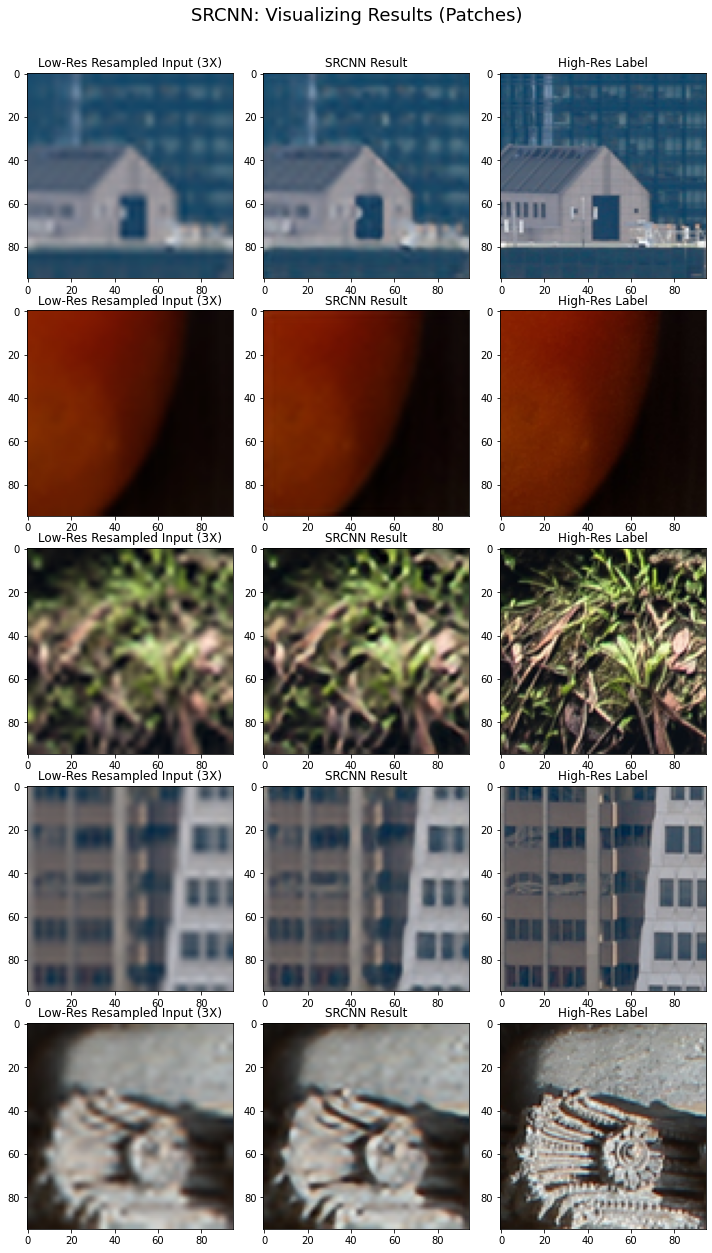

In [26]:
def plot_results(N_of_images_to_plot:int=2, col1:torch.Tensor=None, col2:torch.Tensor=None, col3:torch.Tensor=None, figsize=None, start_from_image=0):
    if figsize == None:
        figsize=(10,N_of_images_to_plot*3.5)
    fig, axs = plt.subplots(N_of_images_to_plot, 3, figsize=figsize)
    fig.suptitle('SRCNN: Visualizing Results (Patches)', fontsize=18, y=1)
    for i, ax in enumerate(axs):
        i+=start_from_image
        ax[0].imshow( cv2.cvtColor(         np.transpose(col1[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[0].set_title("Low-Res Resampled Input ({}X)".format(resolution_div))
        ax[1].imshow( cv2.cvtColor(         np.transpose(col2[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[1].set_title("SRCNN Result")
        ax[2].imshow( cv2.cvtColor(         np.transpose(col3[i], (1, 2, 0) )          , cv2.COLOR_BGR2RGB)           ); ax[2].set_title("High-Res Label")
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.15, hspace=0.05)
    plt.savefig('./results/patch_results/19_SRCNN [{}-epochs] [{}-lr] [{}-optim] [{}-batch_size] [{}-train_size] [{}X] [patch_shape: {}].png'.format(epochs,learning_rate,str(type(optimizer)).split(".")[-1].split("'")[0],batch_size,n_patches,resolution_div, patch_size), dpi=300)

plot_results(5,col1=IN_cpu_np, col2=result_cpu_np, col3=GT_cpu_np, start_from_image=180)
torch.save(mySRCNN.state_dict(),'./results/19_SRCNN [{}-epochs] [{}-lr] [{}-batchsize]'.format(epochs,learning_rate,batch_size))

### Plotting and Saving Loss over Epochs

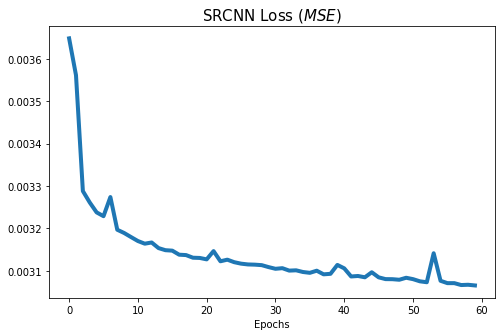

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(loss_vals, linewidth=4)
plt.title('SRCNN Loss ($MSE$)',fontsize=15)
plt.xlabel("Epochs")
plt.savefig('./results/loss/19_SRCNN Loss [{}-epochs] [{}-lr] [{}-optim] [{}-batch_size] [{}-train_size] [{}X].png'.format(epochs,learning_rate,str(type(optimizer)).split(".")[-1].split("'")[0],batch_size,n_patches,resolution_div))

with open('./results/loss/19_SRCNN Loss [{}-epochs] [{}-lr] [{}-optim] [{}-batch_size] [{}-train_size] [{}X].pickle'.format(epochs,learning_rate,str(type(optimizer)).split(".")[-1].split("'")[0],batch_size,n_patches,resolution_div), 'wb') as handle:
    pickle.dump(loss_vals, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Evaluating Metrics (Patches)

In [23]:
patch_res = (255*(result_cpu_np.transpose(0,2,3,1).clip(0,1))).astype(np.uint8)
patch_in = (255*(IN_cpu_np.transpose(0,2,3,1))).astype(np.uint8)
patch_gt = (255*(GT_cpu_np.transpose(0,2,3,1))).astype(np.uint8)

In [27]:
from skimage.metrics import structural_similarity as ssim
# METRICS
result_str = '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ METRIC RESULTS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n'

# PSNR METRIC
result_str += '~~~~~~~~~~~~~>>>PSNR METRIC:\n'
psnr_res_vs_gt = []
psnr_in_vs_gt = []
for i in range(patch_res.shape[0]):
    temp_res_vs_gt = cv2.PSNR(patch_res[i], patch_gt[i])
    temp_in_vs_gt = cv2.PSNR(patch_in[i], patch_gt[i])
    psnr_res_vs_gt.append(temp_res_vs_gt)
    psnr_in_vs_gt.append(temp_in_vs_gt)
    result_str += 'Test Patch N{}\n\tPSNR(Result vs GroundTruth):\t{}\n\tPSNR(Input vs GroundTruth):\t{}\n'.format(i,temp_res_vs_gt,temp_in_vs_gt)
avg_psnr_res_vs_gt = np.mean(psnr_res_vs_gt)
avg_psnr_in_vs_gt = np.mean(psnr_in_vs_gt)
result_str += '\nTotal Average Results (PSNR):\n\tAverage PSNR(Result vs GroundTruth):\t{}\n\tAverage PSNR(Input vs GroundTruth):\t{}\n'.format(avg_psnr_res_vs_gt,avg_psnr_in_vs_gt)

# Average SSIM
result_str += '\n~~~~~~~~~~~~~>>>SSIM METRIC:\n'
avg_ssim_channels_res_vs_gt = []
avg_ssim_channels_in_vs_gt = []
for i in range(patch_res.shape[0]):
    ssim_channel1_res_vs_gt = ssim(patch_res[i][:,:,0],patch_gt[i][:,:,0],data_range=255)
    ssim_channel2_res_vs_gt = ssim(patch_res[i][:,:,1],patch_gt[i][:,:,1],data_range=255)
    ssim_channel3_res_vs_gt = ssim(patch_res[i][:,:,2],patch_gt[i][:,:,2],data_range=255)
    temp_ssim_res_vs_gt = ssim_channel1_res_vs_gt + ssim_channel2_res_vs_gt + ssim_channel3_res_vs_gt / 3
    avg_ssim_channels_res_vs_gt.append(temp_ssim_res_vs_gt)
    ssim_channel1_in_vs_gt = ssim(patch_in[i][:,:,0],patch_gt[i][:,:,0],data_range=255)
    ssim_channel2_in_vs_gt = ssim(patch_in[i][:,:,1],patch_gt[i][:,:,1],data_range=255)
    ssim_channel3_in_vs_gt = ssim(patch_in[i][:,:,2],patch_gt[i][:,:,2],data_range=255)
    temp_ssim_in_vs_gt = ssim_channel1_in_vs_gt + ssim_channel2_in_vs_gt + ssim_channel3_in_vs_gt / 3
    avg_ssim_channels_in_vs_gt.append(temp_ssim_in_vs_gt)
    result_str += 'Test Patch N{}\n\tSSIM(Result vs GroundTruth):\t{}\n\tSSIM(Input vs GroundTruth):\t{}\n'.format(i,temp_ssim_res_vs_gt,temp_ssim_in_vs_gt)
avg_ssim_res_vs_gt = np.mean(avg_ssim_channels_res_vs_gt)
avg_ssim_in_vs_gt = np.mean(avg_ssim_channels_in_vs_gt)
result_str += '\nTotal Average Results (SSIM):\n\tAverage SSIM(Result vs GroundTruth):\t{}\n\tAverage SSIM(Input vs GroundTruth):\t{}\n'.format(avg_ssim_res_vs_gt,avg_ssim_in_vs_gt)

# Average MSE
result_str += '\n~~~~~~~~~~~~~>>>MSE METRIC:\n'
mse_res_vs_gt = []
mse_in_vs_gt = []
avg_ssim_channels_in_vs_gt = []
for i in range(patch_res.shape[0]):
    temp_mse_res_vs_gt = np.square(np.subtract(patch_res[i],patch_gt[i])).mean()
    mse_res_vs_gt.append(temp_mse_res_vs_gt)
    temp_mse_in_vs_gt = np.square(np.subtract(patch_in[i],patch_gt[i])).mean()
    mse_in_vs_gt.append(temp_mse_in_vs_gt)
    result_str += 'Test Patch N{}\n\tMSE(Result vs GroundTruth):\t{}\n\tMSE(Input vs GroundTruth):\t{}\n'.format(i,temp_mse_res_vs_gt,temp_mse_in_vs_gt)
avg_mse_res_vs_gt = np.mean(mse_res_vs_gt)
avg_mse_in_vs_gt = np.mean(mse_in_vs_gt)
result_str += '\nTotal Average Results (MSE):\n\tAverage MSE(Result vs GroundTruth):\t{}\n\tAverage MSE(Input vs GroundTruth):\t{}\n'.format(avg_mse_res_vs_gt,avg_mse_in_vs_gt)
result_str += '\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'

with open('./results/metrics/19 Metric Results [{}-epochs] [{}-lr] [{}-optim] [{}-batch_size] [{}-train_size] [{}X].txt'.format(epochs,learning_rate,str(type(optimizer)).split(".")[-1].split("'")[0],batch_size,n_patches,resolution_div), 'w') as f:
    f.write(result_str)

print(result_str)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ METRIC RESULTS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~>>>PSNR METRIC:
Test Patch N0
	PSNR(Result vs GroundTruth):	37.918582183620195
	PSNR(Input vs GroundTruth):	38.16549285408382
Test Patch N1
	PSNR(Result vs GroundTruth):	31.590548243973018
	PSNR(Input vs GroundTruth):	31.28704203006488
Test Patch N2
	PSNR(Result vs GroundTruth):	32.6100991572918
	PSNR(Input vs GroundTruth):	32.13581138872243
Test Patch N3
	PSNR(Result vs GroundTruth):	25.856126177477456
	PSNR(Input vs GroundTruth):	24.838271699460734
Test Patch N4
	PSNR(Result vs GroundTruth):	19.368626482583938
	PSNR(Input vs GroundTruth):	18.787011473760497
Test Patch N5
	PSNR(Result vs GroundTruth):	32.72575955879317
	PSNR(Input vs GroundTruth):	32.48661966684797
Test Patch N6
	PSNR(Result vs GroundTruth):	30.080111015863974
	PSNR(Input vs GroundTruth):	29.510560778095105
Test Patch N7
	PSNR(Result vs GroundTruth):	27.26726183822054
	PSNR(Input vs GroundTruth):	24.469376322763186
Test Patch N8


## TESTING THE MODEL (BIG IMAGE)

In [49]:
lr_big1 = lr_big[0].to(devO)
hr_big1 = hr_big[0].to(devO)
result_big= mySRCNN(lr_big1.view(-1, *list(lr_big1.shape) ))  # ONLY BIG
big_converted = result_big.cpu().detach().numpy()

Text(0.5, 1.0, 'High_Res Label')

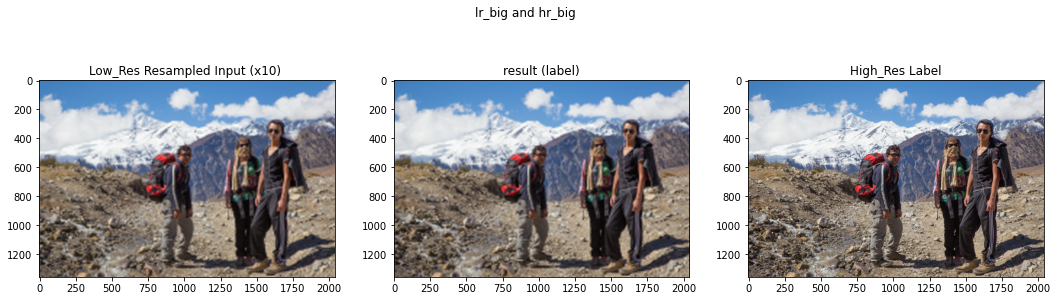

In [64]:
#plot results
plt.figure(figsize = (18,5)); plt.suptitle("lr_big and hr_big")
plt.subplot(131)
plot(lr_big1.cpu());    plt.title("Low_Res Resampled Input (x%d) "% resolution_div)
plt.subplot(132)
plot(lr_big1.cpu());    plt.title("result (label)")
plt.subplot(133)
plot(hr_big1.cpu());    plt.title("High_Res Label")

# How to load the model
In case of need of loading the model from the file run following cell. Warning! mySRCNN will be overwritten!

In [7]:
mySRCNN = SRCNN()
mySRCNN.load_state_dict(torch.load('results/models/19_SRCNN [60-epochs] [0.0001-lr] [Adam-optim] [16-batch_size] [16000-train_size] [3X] [patch_shape: (96, 96)]'))
mySRCNN = mySRCNN.to(devO)
# result_big= mySRCNN(lr_big1.view(-1, *list(lr_big1.shape) ))
# result_final = result_big.cpu().detach().numpy()